In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

df_match = pd.read_csv('/content/drive/MyDrive/DS203_Project/IPL Matches 2008-2020.csv')
df_ball = pd.read_csv('/content/drive/MyDrive/DS203_Project/IPL Ball-by-Ball 2008-2020.csv')

In [3]:
#cleaning starts
df_match = df_match.replace('Rising Pune Supergiant', 'Rising Pune Supergiants')
df_match.loc[df_match['city'].isnull(), 'city'] = df_match[df_match['city'].isnull()]['venue'].apply(lambda x: x.split()[0]) # Dubai and Sharjah filled
df_match = df_match[df_match['winner'].notnull()] # drop rows with unavailable output
df_match['result_margin'] = df_match['result_margin'].fillna(0) # set result_margin of ties to 0
df_match['date'] = pd.to_datetime(df_match['date'], format='%Y-%m-%d')
df_match = df_match.sort_values(by='id').reset_index(drop=True)

df_ball = df_ball[df_ball['id'].isin(df_match['id'])].sort_values(by=['id', 'inning', 'over', 'ball']).reset_index(drop=True)
#cleaning ends
print(df_match.shape)

(812, 17)


In [4]:
print(df_match.head(6).to_string())
print()
print(df_ball.head(6).to_string())

       id        city       date player_of_match                                       venue  neutral_venue                        team1                        team2                  toss_winner toss_decision                       winner   result  result_margin eliminator method    umpire1         umpire2
0  335982   Bangalore 2008-04-18     BB McCullum                       M Chinnaswamy Stadium              0  Royal Challengers Bangalore        Kolkata Knight Riders  Royal Challengers Bangalore         field        Kolkata Knight Riders     runs          140.0          N    NaN  Asad Rauf     RE Koertzen
1  335983  Chandigarh 2008-04-19      MEK Hussey  Punjab Cricket Association Stadium, Mohali              0              Kings XI Punjab          Chennai Super Kings          Chennai Super Kings           bat          Chennai Super Kings     runs           33.0          N    NaN  MR Benson      SL Shastri
2  335984       Delhi 2008-04-19     MF Maharoof                            Fer

EDA Part:

In [5]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

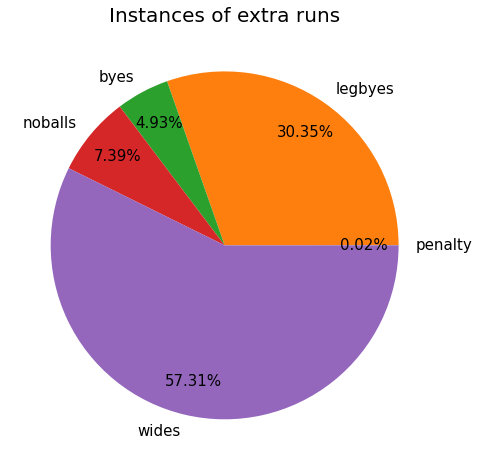

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
freq = df_ball['extras_type'].value_counts(dropna=True)[['penalty', 'legbyes', 'byes', 'noballs', 'wides']]
ax.pie(freq, labels=freq.index, autopct='%1.2f%%', pctdistance=0.8, radius=1, textprops={'fontsize':15})
ax.set_title('Instances of extra runs', fontsize=20)
plt.show()

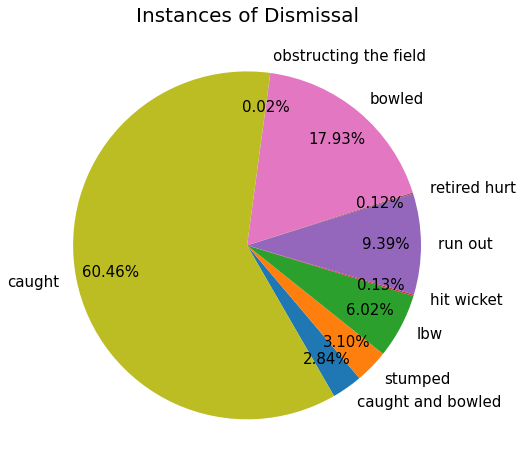

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
freq = df_ball['dismissal_kind'].value_counts(dropna=True)[['caught and bowled', 'stumped', 'lbw', 'hit wicket', 'run out', 'retired hurt', 'bowled', 'obstructing the field', 'caught']]
ax.pie(freq, labels=freq.index, autopct='%1.2f%%', pctdistance=0.8, radius=1, textprops={'fontsize':15}, startangle=-60)
ax.set_title('Instances of Dismissal', fontsize=20)
plt.show()

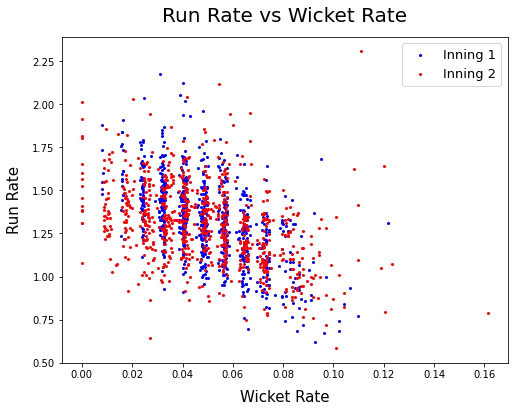

In [8]:
rates = df_ball[['id', 'inning', 'total_runs', 'is_wicket']].groupby(['id', 'inning'], as_index=False).mean().pivot(index='id', columns='inning').reset_index(drop=True).rename(columns={'total_runs':'run_rate', 'is_wicket':'wicket_rate'})

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y=rates['run_rate'][1], x=rates['wicket_rate'][1], c='#0000FF', s=4)
ax.scatter(y=rates['run_rate'][2], x=rates['wicket_rate'][2], c='#FF0000', s=4)
ax.legend(['Inning 1', 'Inning 2'], fontsize=13)
ax.set_xlabel('Wicket Rate', fontsize=15, labelpad=10)
ax.set_ylabel('Run Rate', fontsize=15, labelpad=10)
ax.set_title('Run Rate vs Wicket Rate', fontsize=20, pad=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


[0.47236586 0.18279245]


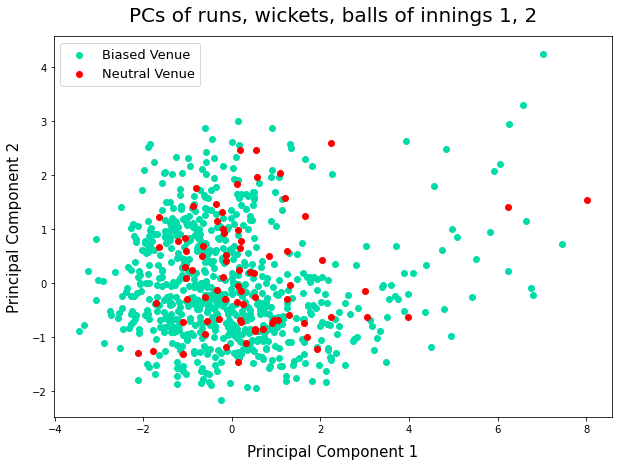

In [ ]:
match_params = df_ball[['id', 'inning', 'total_runs', 'is_wicket']].groupby(['id', 'inning'], as_index=False).sum().pivot(index='id', columns='inning').reset_index(drop=True).rename(columns={'total_runs':'runs', 'is_wicket':'wickets'}).join(
df_ball[['id', 'inning', 'ball']].groupby(['id', 'inning'], as_index=False).count().pivot(index='id', columns='inning').reset_index(drop=True).rename(columns={'ball':'balls'})
)
match_params['runs1'] = match_params['runs'][1]
match_params['runs2'] = match_params['runs'][2]
match_params['wickets1'] = match_params['wickets'][1]
match_params['wickets2'] = match_params['wickets'][2]
match_params['balls1'] = match_params['balls'][1]
match_params['balls2'] = match_params['balls'][2]
match_params.drop(columns=['runs', 'wickets', 'balls'], inplace=True)

standardized = StandardScaler().fit_transform(match_params)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(standardized)
principalDf = pd.DataFrame(data = principalComponents , columns = ['PC1', 'PC2'])
print(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(x=principalDf['PC1'][df_match['neutral_venue']==0], y=principalDf['PC2'][df_match['neutral_venue']==0], c='#00DDAA')
ax.scatter(x=principalDf['PC1'][df_match['neutral_venue']==1], y=principalDf['PC2'][df_match['neutral_venue']==1], c='#FF0000')
ax.legend(['Biased Venue', 'Neutral Venue'], fontsize=13)
ax.set_xlabel('Principal Component 1', fontsize=15, labelpad=10)
ax.set_ylabel('Principal Component 2', fontsize=15, labelpad=10)
ax.set_title('PCs of runs, wickets, balls of innings 1, 2', fontsize=20, pad=15)
plt.show()

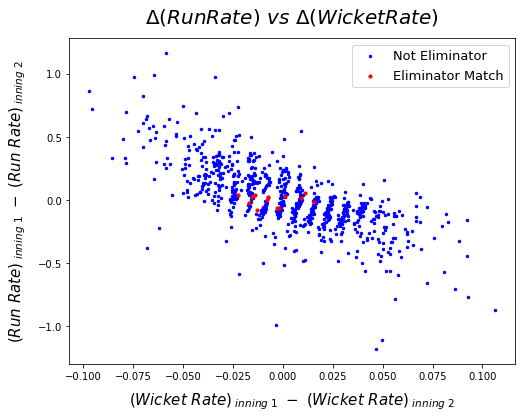

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
x = (rates['wicket_rate'][1]-rates['wicket_rate'][2])
y = (rates['run_rate'][1]-rates['run_rate'][2])
ax.scatter(y=y[df_match['eliminator']=='N'], x=x[df_match['eliminator']=='N'], c='#0000FF', s=6)
ax.scatter(y=y[df_match['eliminator']=='Y'], x=x[df_match['eliminator']=='Y'], c='#FF0000', s=10)
ax.legend(['Not Eliminator', 'Eliminator Match'], fontsize=13)
ax.set_xlabel(r'$(Wicket\ Rate)_{\ inning\ 1}\ - \ (Wicket\ Rate)_{\ inning\ 2}$', fontsize=15, labelpad=10)
ax.set_ylabel(r'$(Run\ Rate)_{\ inning\ 1}\ - \ (Run\ Rate)_{\ inning\ 2}$', fontsize=15, labelpad=10)
ax.set_title(r'$\Delta(Run Rate)\ vs\ \Delta(Wicket Rate)$', fontsize=20, pad=15)
plt.show()

NON EDA Part:

In [ ]:
rates = df_ball[['id', 'inning', 'total_runs', 'is_wicket']].groupby(['id', 'inning'], as_index=False).mean().pivot(index='id', columns='inning').reset_index(drop=True)

df_match['run_rate_inning1'] = rates['total_runs'][1]
df_match['run_rate_inning2'] = rates['total_runs'][2]
df_match['wicket_rate_inning1'] = rates['is_wicket'][1]
df_match['wicket_rate_inning2'] = rates['is_wicket'][2]

df_match['win'] = (df_match['run_rate_inning1']/(12*df_match['wicket_rate_inning1']).clip(1) - df_match['run_rate_inning2']/(12*df_match['wicket_rate_inning2']).clip(1))

neg_ind = ((df_match['toss_decision']=='bat') ^ (df_match['toss_winner']==df_match['team1']))
df_match['win'].loc[neg_ind] = - df_match['win'].loc[neg_ind]
print(df_match.head(20).to_string())
print(df_match[df_match['result']=='tie'].to_string())

        id        city        date player_of_match                                       venue  neutral_venue                        team1                        team2                  toss_winner toss_decision                       winner   result  result_margin eliminator method      umpire1         umpire2  run_rate_inning1  run_rate_inning2  wicket_rate_inning1  wicket_rate_inning2       win
0   335982   Bangalore  2008-04-18     BB McCullum                       M Chinnaswamy Stadium              0  Royal Challengers Bangalore        Kolkata Knight Riders  Royal Challengers Bangalore         field        Kolkata Knight Riders     runs          140.0          N    NaN    Asad Rauf     RE Koertzen          1.790323          0.811881             0.024194             0.099010 -1.106989
1   335983  Chandigarh  2008-04-19      MEK Hussey  Punjab Cricket Association Stadium, Mohali              0              Kings XI Punjab          Chennai Super Kings          Chennai Super Kings      

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
#Encoding/Transforming
from sklearn.preprocessing import LabelEncoder

encoder= LabelEncoder()

variables = pd.DataFrame()
#variables['city'] = encoder.fit_transform(df_match['city'])
#variables['year'] = df_match['date'].dt.year
variables['day_of_year'] = df_match['date'].dt.dayofyear
#variables['venue'] = encoder.fit_transform(df_match['venue'])
variables['neutral_venue'] = df_match['neutral_venue']
variables['team1'] = encoder.fit_transform(df_match['team1'])
variables['team2'] = encoder.fit_transform(df_match['team2'])
variables['toss_team1'] = (df_match['team1']==df_match['toss_winner']).astype(int)
variables['toss_bat'] = (df_match['toss_decision']=='bat').astype(int)
variables['eliminator'] = (df_match['eliminator']=='Y').astype(int)
variables['method'] = (df_match['method']=='D/L').astype(int)
#variables['umpire1'] = encoder.fit_transform(df_match['umpire1'])
#variables['umpire2'] = encoder.fit_transform(df_match['umpire2'])

In [ ]:
quality = (pd.get_dummies(df_match['winner']).cumsum() / (pd.get_dummies(df_match['team1']) + pd.get_dummies(df_match['team2'])).cumsum()).fillna(1)
quality.loc[-1, :] = 1
quality.index += 1
quality = quality.sort_index()[:-1]
print(quality.to_string())

for i in variables.index:
  variables.loc[i, 'quality1'] = quality.loc[i, df_match.loc[i, 'team1']]
  variables.loc[i, 'quality2'] = quality.loc[i, df_match.loc[i, 'team2']]

     Chennai Super Kings  Deccan Chargers  Delhi Capitals  Delhi Daredevils  Gujarat Lions  Kings XI Punjab  Kochi Tuskers Kerala  Kolkata Knight Riders  Mumbai Indians  Pune Warriors  Rajasthan Royals  Rising Pune Supergiants  Royal Challengers Bangalore  Sunrisers Hyderabad
0               1.000000         1.000000        1.000000          1.000000       1.000000         1.000000              1.000000               1.000000        1.000000       1.000000          1.000000                 1.000000                     1.000000             1.000000
1               1.000000         1.000000        1.000000          1.000000       1.000000         1.000000              1.000000               1.000000        1.000000       1.000000          1.000000                 1.000000                     0.000000             1.000000
2               1.000000         1.000000        1.000000          1.000000       1.000000         0.000000              1.000000               1.000000        1.000000 

In [ ]:
variables['win_team1'] = (df_match['team1']==df_match['winner']).astype(int) # to be changed

print(variables.head(812).to_string())
print(variables.shape)
print(df_match.shape)

     day_of_year  neutral_venue  team1  team2  toss_team1  toss_bat  eliminator  method  quality1  quality2  win_team1
0            109              0     12      7           1         0           0       0  1.000000  1.000000          0
1            110              0      5      0           0         1           0       0  1.000000  1.000000          0
2            110              0      3     10           0         1           0       0  1.000000  1.000000          1
3            111              0      8     12           1         1           0       0  1.000000  0.000000          0
4            111              0      7      1           0         1           0       0  1.000000  1.000000          1
5            112              0     10      5           0         1           0       0  0.000000  0.000000          1
6            113              0      1      3           1         1           0       0  0.000000  1.000000          0
7            114              0      0      8   

In [ ]:
from sklearn.model_selection import train_test_split

X, y = variables.iloc[:, :-1], variables['win_team1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1, shuffle=False)

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, 
                    hidden_layer_sizes=(50, 10), 
                    alpha=0.001, 
                    learning_rate_init=0.01, 
                    batch_size=5, 
                    activation='relu'
                    ).fit(X_train, y_train)
print('Validation Score = ', clf.score(X_val, y_val))
print('Test Score = ', clf.score(X_test, y_test))

Validation Score =  0.5655737704918032
Test Score =  0.5737704918032787
